
# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

● ‘ScheduledDay’ tells us on what day the patient set up their appointment.

● ‘Neighborhood’ indicates the location of the hospital.

● ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.

● Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.



### Question(s) for Analysis

What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb


In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

In this section, the data will be loaded and checked for cleanliness, then trim and clean the data for analysis


### General Properties


In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Check for duplicate values
df.duplicated().sum() 

0

In [5]:
# Check for duplicated patient IDs
df['PatientId'].duplicated().sum()

48228

In [6]:
# Check for duplicated patient IDs with NO show statues
df.duplicated(['PatientId','No-show']).sum()

38710

In [7]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [8]:
# Checking for some info about the dataset 
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [9]:
# Noticed there is an age of -1 'Incorrect value'
# Getting the row index of -1 value for the age
df.query('Age=="-1"')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No



### Data Cleaning
In this section we will prepar the data for analysis by removing or modifying data that is incorrect, incomplete, irrelevant, duplicated, or improperly formatted
 

In [10]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
# Removing the row with the -1 value for the age, row 99832
df.drop(index=99832,inplace=True)
df.describe()


,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [11]:
# Removing duplicated IDs with duplicated showing statues
df.drop_duplicates(['PatientId','No-show'],inplace = True)
df.duplicated(['PatientId','No-show']).sum()

0

In [12]:
df.rename(columns={'No-show':'No_show'},inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='eda'></a>
## Exploratory Data Analysis

>Now that we have trimmed and cleaned our data, ready to move to exploration. Computing statitics and creating visualization with the goal of addressing the research question that we posed in the introduction section


In [13]:
#Deviding the patients into two groups based on showing or no show
Patient_Show = df.No_show == 'No'
Patient_No_Show = df.No_show == 'Yes'
df[Patient_Show].count() , df[Patient_No_Show].count()

(PatientId         54153
 AppointmentID     54153
 Gender            54153
 ScheduledDay      54153
 AppointmentDay    54153
 Age               54153
 Neighbourhood     54153
 Scholarship       54153
 Hipertension      54153
 Diabetes          54153
 Alcoholism        54153
 Handcap           54153
 SMS_received      54153
 No_show           54153
 dtype: int64, PatientId         17663
 AppointmentID     17663
 Gender            17663
 ScheduledDay      17663
 AppointmentDay    17663
 Age               17663
 Neighbourhood     17663
 Scholarship       17663
 Hipertension      17663
 Diabetes          17663
 Alcoholism        17663
 Handcap           17663
 SMS_received      17663
 No_show           17663
 dtype: int64)

In [14]:
# Checking the average values in each column for each group 
df[Patient_Show].mean()
df[Patient_No_Show].mean()

PatientId        1.460285e+14
AppointmentID    5.648098e+06
Age              3.437627e+01
Scholarship      1.084187e-01
Hipertension     1.709223e-01
Diabetes         6.510785e-02
Alcoholism       2.944007e-02
Handcap          1.777727e-02
SMS_received     4.530940e-01
dtype: float64

### Research Question 1 (Does recieving SMS notification affect patient's attendance?)

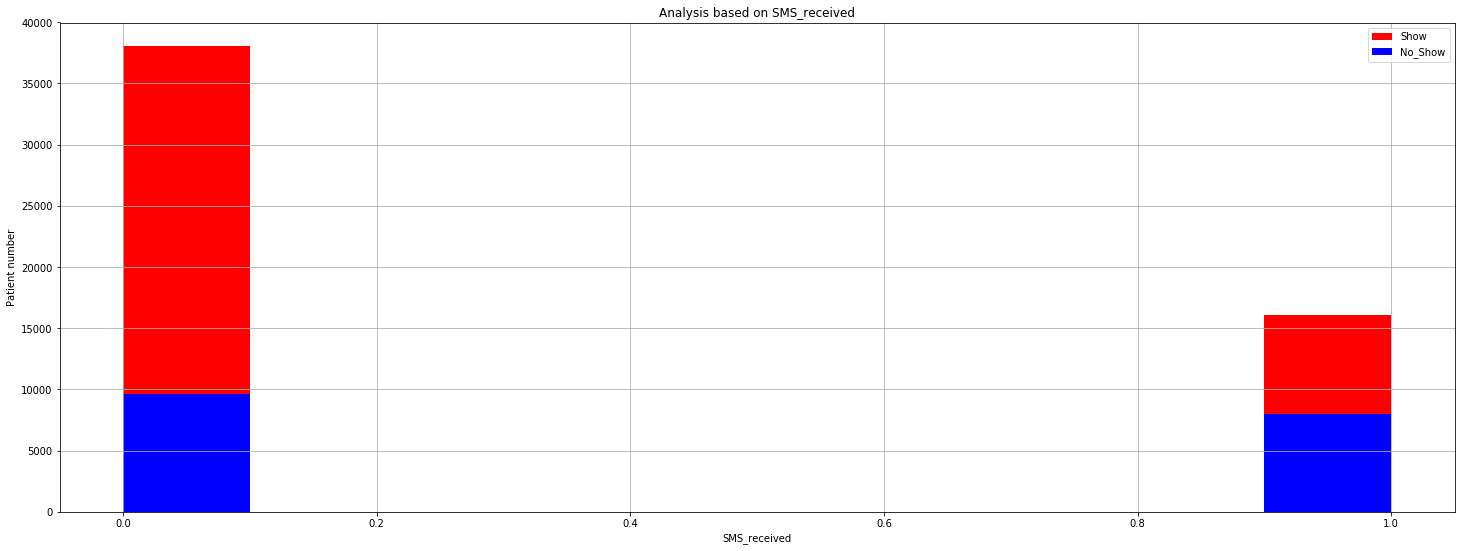

In [15]:
def patient_attendance(df, column_name, Show, No_Show):
    plt.figure(figsize = [25,9])
    df[column_name][Patient_Show].hist(alpha=1, bins=10, color='red', label='Show')
    df[column_name][Patient_No_Show].hist(alpha=1, bins=10, color='blue', label='No_Show')
    plt.legend()
    plt.title("Analysis based on SMS_received")
    plt.xlabel('SMS_received')
    plt.ylabel('Patient number')
patient_attendance(df, 'SMS_received', Patient_Show, Patient_No_Show)    

### Research Question 2  (Does the gender affect patient attendance?)

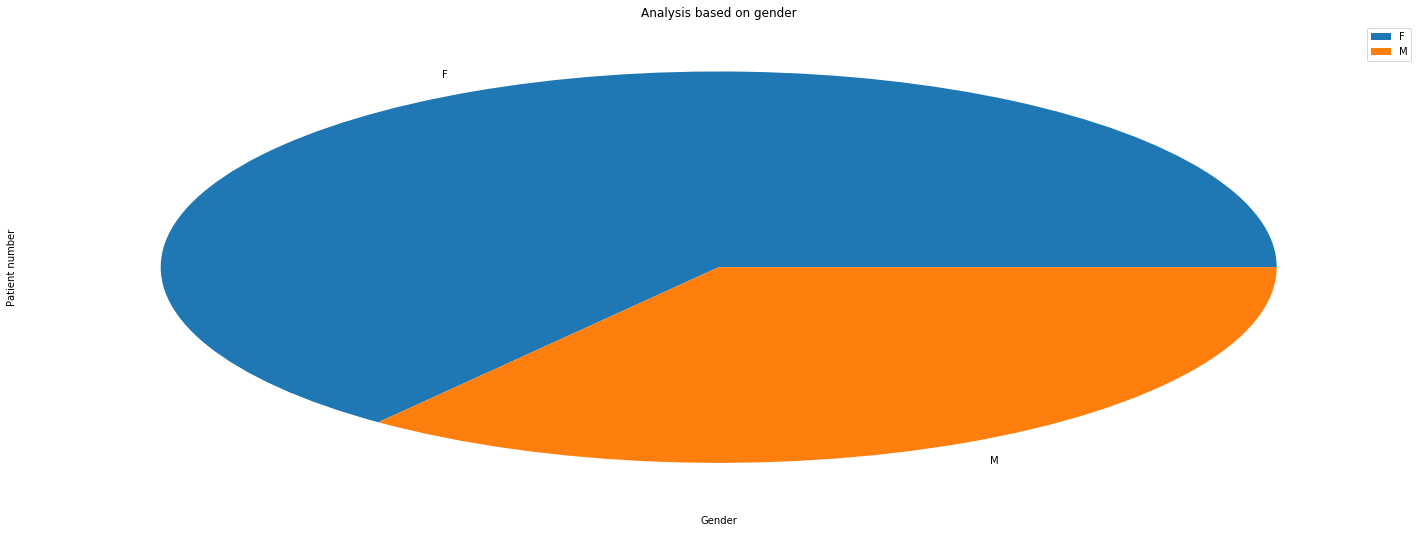

In [16]:
def patient_attendance(df, column_name, Show, No_Show):
    plt.figure(figsize = [25,9])
    df[column_name][Patient_Show].value_counts(normalize = True).plot(kind = 'pie', label = 'Show')
    plt.legend()
    plt.title("Analysis based on gender")
    plt.xlabel('Gender')
    plt.ylabel('Patient number')
patient_attendance(df, 'Gender', Patient_Show, Patient_No_Show)

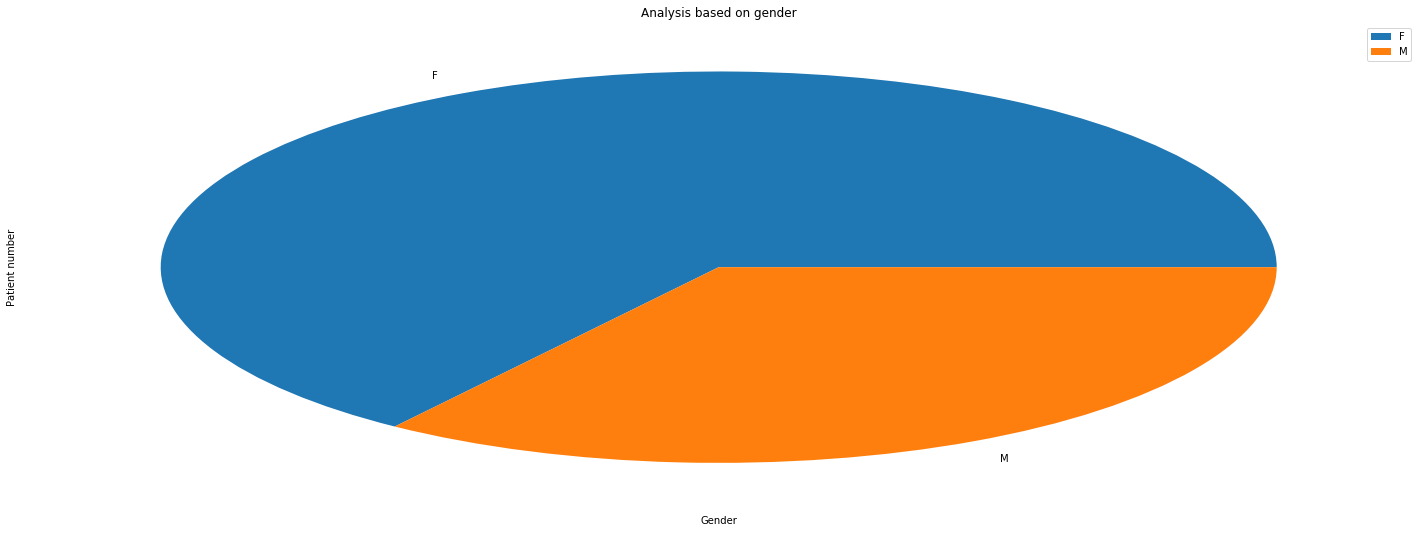

In [17]:
def patient_attendance(df, column_name, Show, No_Show):
    plt.figure(figsize = [25,9])
    df[column_name][Patient_No_Show].value_counts(normalize = True).plot(kind = 'pie', label = 'No_Show')
    plt.legend()
    plt.title("Analysis based on gender")
    plt.xlabel('Gender')
    plt.ylabel('Patient number')
patient_attendance(df, 'Gender', Patient_Show, Patient_No_Show)

<a id='conclusions'></a>
## Conclusions

Regarding research quistion number one, after analysis we found that recieving a notificaation SMS, dosn't affect patients not showing, but greatly affects patients attendance, which can mean that when patients don't get a notification SMS, they feel obligated to make their appointments.  

Regarding research question number two, after analysis we found that gender does not have a huge influence over the attendance of patients, but there is a slight increase in attendance when it comes to female patients

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [18]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0